# Project: Spaceship Titanic

In this project our task is to predict whether a passenger was transported  
to an alternate dimension during the Spaceship Titanic's collision with  
the spacetime anomaly. To help make these predictions, we are given a set of  
personal records recovered from the ship's damaged computer system

#### Libraries that will be used in project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand
import scipy.stats as stats
from sklearn.impute import SimpleImputer

In [2]:
# Path to train and test files
path_train = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint3\project\train.csv"
path_test = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint3\project\test.csv"

# Get panda's dataframe and shape
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)
print(f"Train df shape: {train.shape}")
print(f"Test df shape: {test.shape}")

Train df shape: (8693, 14)
Test df shape: (4277, 13)


In [3]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [4]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


We shall look at basic structure of dataframe

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


There are 3 data types: object(7), float(6) and boolean (target). 13 columns of  
features and 1 target named "Transported"

## Data cleaning

*For the following steps of data cleaning: data will be cleaned only for train  
df but every change in dataframe (columns, labels, etc.) will be added for test  
df when latter is used*

First of all let's make all letters in columns labels to lower case, remove  
empty spaces in order to simplicity and convenience. Also check for duplicates,  
NaN numbers and empty cells

In [6]:
train_df = train.copy()
train_df = sand.cleaner(train_df)

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: False
Is there any NaN numbers?: True
Is there any empty cells?: False


Function says that there are some NaNs in df. These must be evaluated and  
fixed. Firstly, we need to find which features have NaNs

In [7]:
nans = train_df.isna().sum()
percentage = (nans / len(train_df)) * 100
pd.DataFrame({"nan_count": nans, "perentage(%)": round(percentage, 2)})

,nan_count,perentage(%)
passengerid,0,0.00
homeplanet,201,2.31
cryosleep,217,2.50
cabin,199,2.29
destination,182,2.09
age,179,2.06
vip,203,2.34
roomservice,181,2.08
foodcourt,183,2.11
shoppingmall,208,2.39


Most of features on average have ~2% NaNs. We need to fill  empty spaces (NaNs)  
of each column. To fill numeric values, I am using mean value of column and for  
categorical - imputation methon with SimpleIputer function 

In [8]:
# create imputer variables for numeric and categoric features
numerical_imp = SimpleImputer(strategy="mean")
categorical_imp = SimpleImputer(strategy="most_frequent")
numericals = ["age", "roomservice", "foodcourt", "shoppingmall", "spa", "vrdeck"]
categoricals = ["homeplanet", "cryosleep", "cabin", "destination", "vip", "name"]

# fill empty cells using imputation method
train_df[numericals] = numerical_imp.fit_transform(train_df[numericals])
train_df[categoricals] = categorical_imp.fit_transform(train_df[categoricals])

train_df.isna().any().any()
# Issiaiskinti ar tikrai galima fillinti cabin su most frequent nes keista
# kai random toje pacioje kabinoje skirtingi zmones butu???????

False

As we can see from function .any().any() there are no NaNs left meaning we  
successfully filled empty cells

Now we can check numeric values with .describe() to look deeper in numeric  
data

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8693.0,28.827930,14.339054,0.0,20.0,27.0,37.0,79.0
roomservice,8693.0,224.687617,659.739364,0.0,0.0,0.0,78.0,14327.0
foodcourt,8693.0,458.077203,1594.434978,0.0,0.0,0.0,118.0,29813.0
shoppingmall,8693.0,173.729169,597.417440,0.0,0.0,0.0,45.0,23492.0
spa,8693.0,311.138778,1124.675871,0.0,0.0,0.0,89.0,22408.0
vrdeck,8693.0,304.854791,1133.259049,0.0,0.0,0.0,71.0,24133.0


We can see that all of numeric features have relatively high values in mean and  
even higher in std. Since float type is usually used for smaller numbers or  
strong accuracy, with these numbers float doesn't has huge impact and it could  
be converted to integer. Age feature is usually written in int dtype and can be  
converted too

In [10]:
# converting from float to int
train_df[numericals] = train_df[numericals].astype(int)

## Exploratory Data Analysis (EDA)

Since dataset has been fairly cleaned, some insights could be looked for to  
get deeper view. Firstly, we can check our main project's target  
feature - Transported 

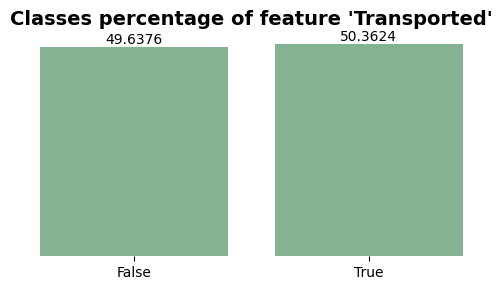

In [11]:
sand.f_countplot(
    data=train_df, 
    xaxis="transported",
    stat="percent", 
    title="Classes percentage of feature 'Transported'"
)

As we can see from plot, both values percent are very similar showing strong  
indicator of strongly balanced classes. This  could be benefit on ML modeling  
part

#### Numeric data

We can look at distribution of age combined with hued target

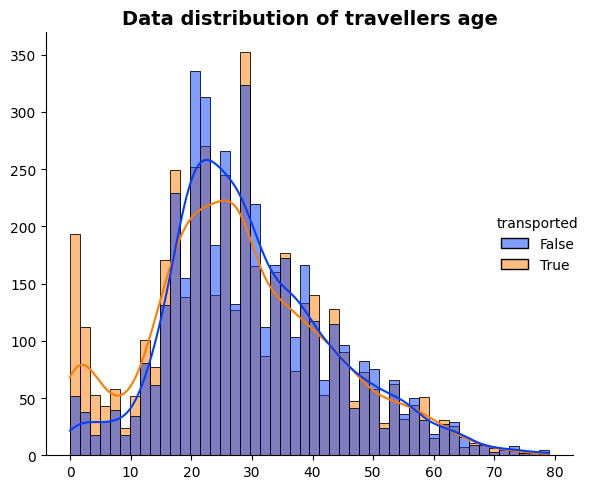

In [13]:
sand.f_displot(
    data=train_df,
    xaxis="age",
    hue="transported",
    palette="bright",
    kde=True,
    title="Data distribution of travellers age"
)

From distribution plot we can see that data isn't normally distributed. People  
0-15 age were more likely to be transported. Most of the travellers were on  
age interval 20-30 as well as higher number of which weren't transported. From  
age 40 to 80 transported and untransported people count was fairly similar